A 动作

R 奖励

动作的期望奖励Q

最优奖励

$Q^* = \max_{a \in A} Q(a)$

regret:

$R(a)=Q^*(a)-Q(a)$

最大化累积奖励

最小化累积懊悔

algo：
N=0,Q=0#初始化
for t in Time:
    at#动作
    rt#奖励
    N+=1#更新计数器
    Q+= 1/N(r-Q)#更新奖励

迭代原理如下：

很抱歉给你造成了困扰，以下是用$符号的结果：

$Q_k = \frac{1}{k} \sum_{i = 1}^{k} r_i$

$= \frac{1}{k} ( r_k + \sum_{i = 1}^{k - 1} r_i )$

$= \frac{1}{k} ( r_k + (k - 1)Q_{k - 1} )$

$= \frac{1}{k} ( r_k + kQ_{k - 1} - Q_{k - 1} )$

$= Q_{k - 1} + \frac{1}{k} [ r_k - Q_{k - 1} ]$


In [69]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1) 
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx] 
        self.K=K
    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

K = 10
bandit_10_arm = BernoulliBandit(K)
print(f'{bandit_10_arm.best_idx, bandit_10_arm.best_prob}')




(np.int64(1), np.float64(0.7203244934421581))


In [70]:
class Solver:
    def __init__(self, bandit):
       self.bandit = bandit
       self.counts = np.zeros(self.bandit.K)
       self.regret = 0.
       self.actions = []
       self.regrets = []
    def update_regret(self,k):
        self.regret+=self.bandit.best_prob-self.bandit.probs[k]
        self.regrets.append(self.regret)
    def run_one_step(self):
        raise NotImplementedError
    def run(self,num_steps):
        for _ in range(num_steps):
            k=self.run_one_step()
            self.counts[k]+=1
            self.actions.append(k)
            self.update_regret(k)
     

$\epsilon -greedy$


$
a_t = 
\begin{cases}
\arg\max_{a \in A} \hat{Q}(a), & \text{采样概率: } 1 - \epsilon \\
\text{从 } A \text{ 中随机选择}, & \text{采样概率: } \epsilon
\end{cases}
$

In [71]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit,epsilon=0.01,init_prob=1.0):
        super().__init__(bandit)
        self.epsilon=epsilon
        self.estimates=np.array([init_prob]*self.bandit.K)
    def run_one_step(self):
        if np.random.random()<self.epsilon:
            k=np.random.randint(0,self.bandit.K)
        else:
            k=np.argmax(self.estimates)
        r=self.bandit.step(k)
        self.estimates[k]+=1./(self.counts[k]+1)*(r-self.estimates[k])
        return k
    
        

In [72]:
#画图
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

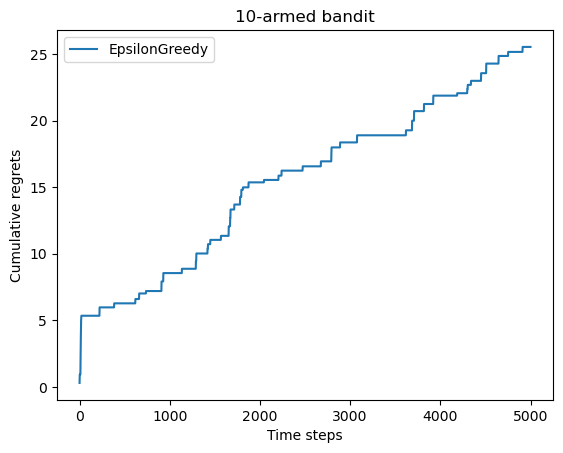

In [73]:
np.random.seed(1)
e_solver=EpsilonGreedy(bandit_10_arm)
e_solver.run(5000)
plot_results([e_solver], ["EpsilonGreedy"])


累积懊悔都是线性增长的。在这个例子中，随着 $\epsilon$的增大，累积懊悔增长的速率也会增大
可以让 $\epsilon$随时间反比例变化


epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


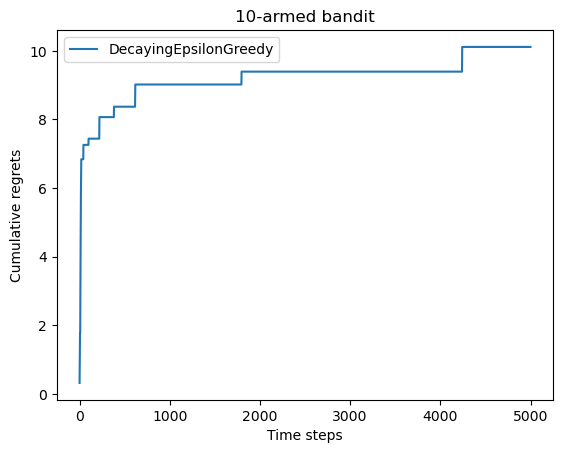

In [74]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1#每次步进1，放在分母
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

UCB 算法

Hoeffding's inequality  $X_i$ idd

$P \{ \mathbb{E} [X] \geq \bar{x}_n + u \} \leq e^{-2nu^2}$

u代表不确定性度量

$Q_t(a)$带入$\bar{x}_{t}$

$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a) \text{ 至少以概率 } 1 - p \text{ 成立。}$


p很小时很大概率成立$ \hat{Q}_t(a) + \hat{U}_t(a)$是期望上界

上置信界算法便选取期望奖励上界最大的动作

$a = \arg\max_{a \in A} [\hat{Q}(a) + \hat{U}(a)]$

$$
e^{-2N_{t}(a)U_{t}(a)^{2}} \Rightarrow \hat{U}_{t}(a)=\sqrt{\frac{-\log p}{2N_{t}(a)}}
$$

在具体的实现过程中，设置$p=1/t$ ，并且在分母中为拉动每根拉杆的次数加上常数 1，以免出现分母为 0 的情形，

$$
e^{-2N_{t}(a)U_{t}(a)^{2}} \Rightarrow \hat{U}_{t}(a)=\sqrt{\frac{-\log p}{2N_{t}(a)+1}}
$$


上置信界算法的累积懊悔为： 70.45281214197854


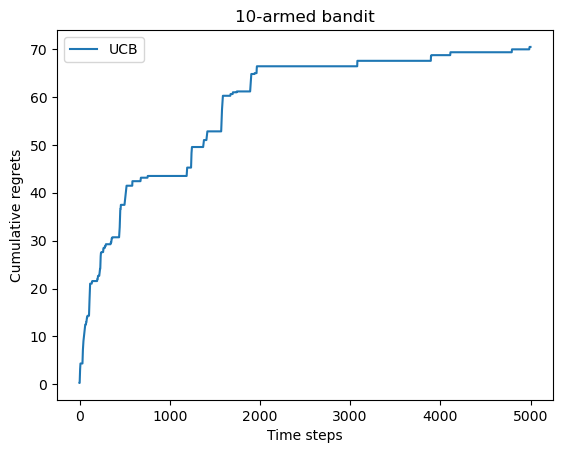

In [75]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

Thompson sampling

先假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。但是由于计算所有拉杆的期望奖励的代价比较高，汤普森采样算法使用采样的方式，即根据当前每个动作a的奖励概率分布进行一轮采样，得到一组各根拉杆的奖励样本，再选择样本中奖励最大的动作。可以看出，汤普森采样是一种计算所有拉杆的最高奖励概率的蒙特卡洛采样方法。

实际情况中，我们通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了 k次，其中 m次奖励为 1， n次奖励为 0，则该拉杆的奖励服从参数为(m+1,n+1) 的 Beta 分布

汤普森采样算法的累积懊悔为： 57.19161964443925


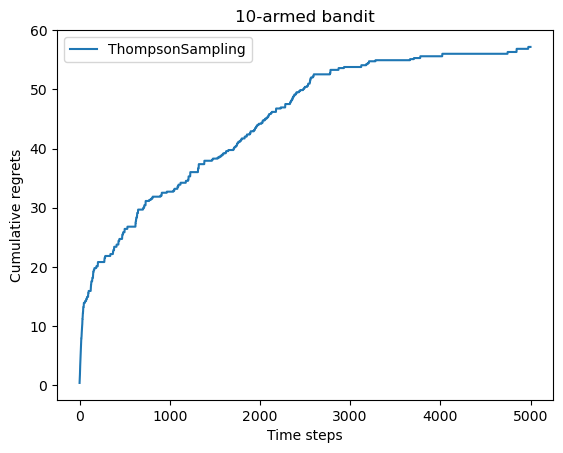

In [76]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])